In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

In [63]:
DATA = 'gene'
dataset_dir = '../../data/'
save_dir = '../data/'
bulkseq_dataset = 'Degnorm_JS_1394ESGs.csv'
switch_dataset = "switch_genelist.csv"
meta_dataset = 'NGJ_Switches_28Sept2023.csv'

# Read Switches

In [64]:
if DATA == 'switch':
	switch_df = pd.read_csv(dataset_dir + switch_dataset, index_col=0)
	# drop first column
	switch_df = switch_df.drop(switch_df.columns[0], axis=1)

	# switch df to dict
	switch_dict = {}
	for row in switch_df.index:
		switch_dict[row] = switch_df.loc[row].dropna().tolist()

# Read Bulk Seq Dataset

In [65]:
Exp = pd.read_csv(dataset_dir + bulkseq_dataset, index_col=0).T

# bulk seq dataset is in Jane Score
print(Exp.min().min(), Exp.max().max())

0.0 28.1538


In [66]:
if DATA == 'switch':
	# transform Exp to switch
	# compare genes in switches with genes in rpkm
	switch_genes = [gene for switch in switch_dict.keys() for gene in switch_dict[switch]]
	# change to set
	switch_genes = set(switch_genes)
	exp_genes = set(Exp.T.index)

	# find overlapping genes
	overlapping_genes = switch_genes.intersection(exp_genes)
	print(len(switch_genes), len(exp_genes), len(overlapping_genes))

	# filter non-overlapping genes from switches
	for switch in switch_dict.keys():
		switch_dict[switch] = list(set(switch_dict[switch]).intersection(overlapping_genes))

	# aggregate rpkm columns using switch_dict
	Exp_new = pd.DataFrame(columns=Exp.T.columns, index=switch_dict.keys())
	for i in switch_dict.keys():
		Exp_new.loc[i] = np.mean(Exp.T.loc[switch_dict[i]].values, axis=0)

	Exp = Exp_new.T

	# save Exp
	bulkseq_dataset_name = bulkseq_dataset.split('.')[0]
	Exp.to_csv(save_dir + bulkseq_dataset_name + '_switch.csv')


In [67]:
metadata_df = pd.read_csv(dataset_dir + meta_dataset, index_col=0)
metadata_df.head()

,Age,Surgery,Surgery.Date,Collection.Date,Endo,Endo.Case.Control,Endo.Training,Adeno,Fibroids,PCOS,...,Th2cellsIRIS3,TregsBLUEPRINT1,TregsBLUEPRINT2,TregsBLUEPRINT3,TregsFANTOM1,TregsFANTOM2,TregsFANTOM3,TregsHPCA1,TregsHPCA2,TregsHPCA3
Patient,,,,,,,,,,,,,,,,,,,,,
E01-A0001,32,PRE,no surgery date,4/28/21,1,Suspected,No,-2,-1,-2,...,0.37585,0.79800,0.6299,1.0514,0.6299,1.0514,0.4732,0.52760,0.01000,0.0100
E01-A0001,32,PRE,no surgery date,7/12/21,1,Suspected,No,-2,-1,-2,...,0.01000,1.09685,0.8891,1.1976,0.8891,1.1976,0.6971,0.33890,0.04255,0.0751
E01-A0002,34,PRE,8/12/21 0:00,8/10/21,2,Case,No,0,-1,-2,...,0.45125,1.11295,0.7453,1.3172,0.7453,1.3172,0.7453,0.37765,0.01000,0.0100
E01-A0002,34,PRE,8/12/21 0:00,8/11/21,2,Case,No,0,-1,-2,...,1.57300,2.55875,2.6503,2.8033,2.6503,2.8033,2.4903,1.25915,0.68150,0.9576
E01-A0003,39,POST,4/9/21 0:00,8/18/21,0,Other,Yes,-2,-1,-2,...,1.87580,2.68285,2.4446,2.8311,2.4446,2.8311,2.4446,1.17260,0.57660,0.5947


In [68]:
# keep only samples that pass Columbia QC
size_bf = metadata_df.shape[0]
metadata_df = metadata_df[metadata_df['Columbia QC'] == 'Pass']
size_after = metadata_df.shape[0]
print(f'Number of samples before: {size_bf}, after: {size_after}')

Number of samples before: 1394, after: 884


In [69]:
# remove duplicate kits, keep later one
size_bf = metadata_df.shape[0]
metadata_df.sort_values(by=['Clinical.QC', 'Research.QC'], inplace=True)
metadata_df.drop_duplicates(subset=['Kit'], keep='last', inplace=True)
size_after = metadata_df.shape[0]
print(f'Number of samples before: {size_bf}, after: {size_after}')

Number of samples before: 884, after: 588


In [70]:
size_bf = metadata_df.shape[0]
# drop rows with negative day values
metadata_df = metadata_df[metadata_df['Cycle.Day'] > 0]
# drop rows with day > 5
metadata_df = metadata_df[metadata_df['Cycle.Day'] <= 5]

size_after = metadata_df.shape[0]
print(f'Number of samples before: {size_bf}, after: {size_after}')

Number of samples before: 588, after: 583


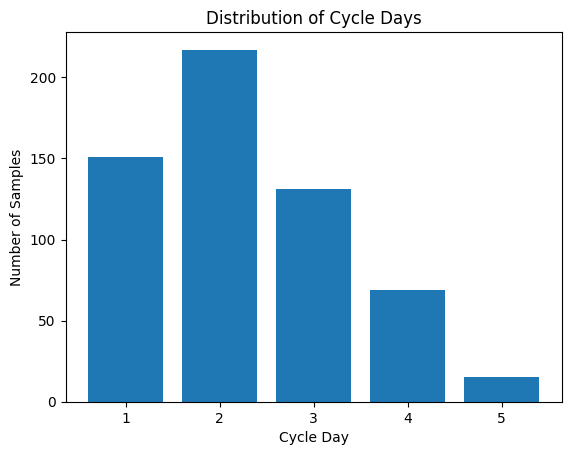

In [71]:
days_dist = dict()
for d in  metadata_df['Cycle.Day'].unique():
	days_dist[d] = (metadata_df['Cycle.Day'] == d).sum()

plt.bar(days_dist.keys(), days_dist.values())
plt.xlabel('Cycle Day')
plt.ylabel('Number of Samples')
plt.title('Distribution of Cycle Days')
plt.savefig('../plots/cycle_days_dist.png')

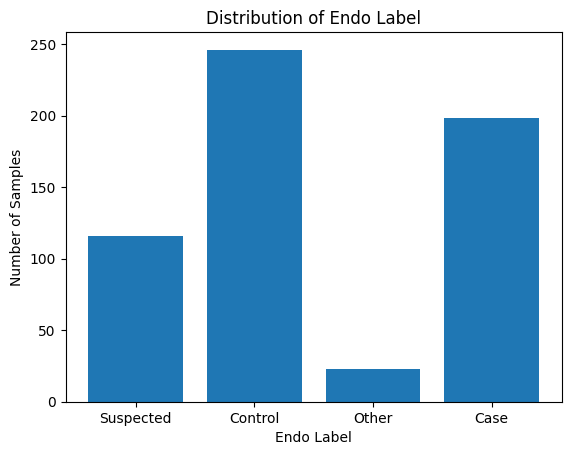

In [72]:
days_dist = dict()
for d in  metadata_df['Endo.Case.Control'].unique():
	days_dist[d] = (metadata_df['Endo.Case.Control'] == d).sum()

plt.bar(days_dist.keys(), days_dist.values())
plt.xlabel('Endo Label')
plt.ylabel('Number of Samples')
plt.title('Distribution of Endo Label')
plt.savefig('../plots/endo_label_dist.png')

In [73]:
endo_map = {'Suspected': 0.5, 'Control': 0, 'Case': 1, 'Other': -1}
metadata_df['Endo.Case.Control'] = metadata_df['Endo.Case.Control'].map(endo_map)

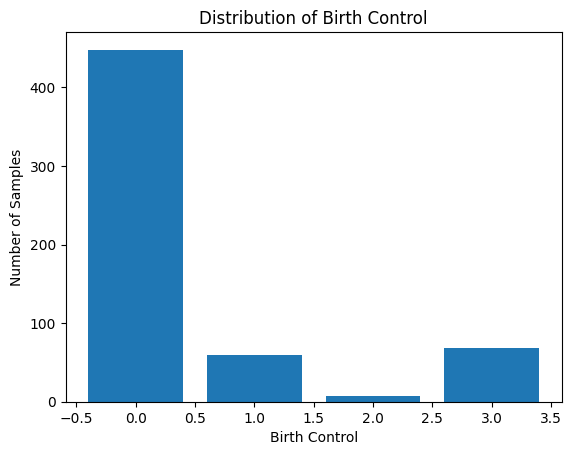

In [74]:
# plot dist of birth control
birth_map = {0: 0, 2: 1, 5: 2, 6: 2, 7: 1, 4:3, -3:3, 3:3, -1:3, -2:3, 1:3, 8:3}
days_dist = dict()
days_dist[0] = 0
days_dist[1] = 0
days_dist[2] = 0
days_dist[3] = 0

for d in  metadata_df['Birth.Control'].unique():
	label = birth_map[d]
	days_dist[label] += (metadata_df['Birth.Control'] == d).sum()

plt.bar(days_dist.keys(), days_dist.values())
plt.xlabel('Birth Control')
plt.ylabel('Number of Samples')
plt.title('Distribution of Birth Control')
plt.savefig('../plots/birth_control_dist_4groups.png')

In [75]:
# add column to encode Birth.Control
metadata_df['Birth.Control'] = metadata_df['Birth.Control'].map(birth_map)

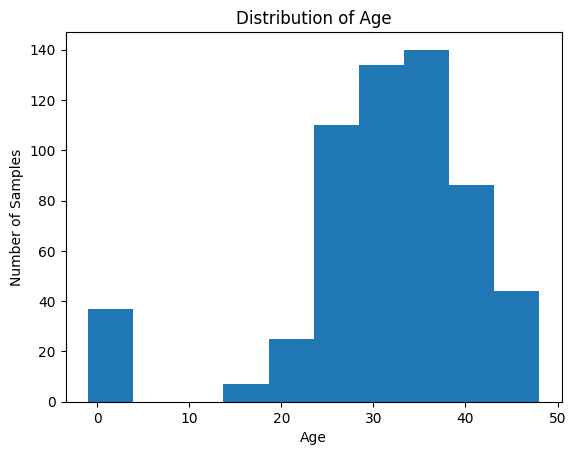

In [76]:
# plot dist of age
plt.hist(metadata_df['Age'])
plt.xlabel('Age')
plt.ylabel('Number of Samples')
plt.title('Distribution of Age')
plt.savefig('../plots/age_dist.png')

In [77]:
# add column to bucket age into 6 groups
age_binned = []
for age in metadata_df['Age']:
	if age == -1:
		age_binned.append(-1)
	elif age <= 29:
		age_binned.append(0)
	elif age <= 35:
		age_binned.append(1)
	elif age <= 40:
		age_binned.append(2)
	else:
		age_binned.append(3)

metadata_df['Age.Binned'] = age_binned

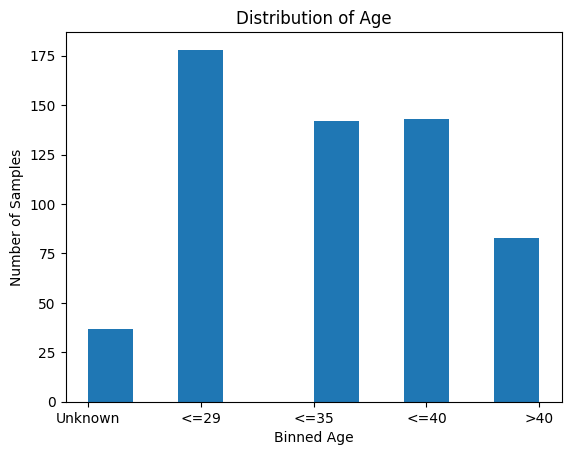

In [78]:
# replot dist of age
plt.hist(metadata_df['Age.Binned'])
plt.xticks([-1, 0, 1, 2, 3], ['Unknown', '<=29', '<=35', '<=40', '>40'])
plt.xlabel('Binned Age')
plt.ylabel('Number of Samples')
plt.title('Distribution of Age')
plt.savefig('../plots/age_binned_dist_5groups.png')

In [79]:
metaData_col = ['ESG', 'Cycle.Day', 'Endo.Case.Control', 'Age.Binned', 'Cycle', 'Birth.Control']
metaData = metadata_df[metaData_col]
metaData.head()

,ESG,Cycle.Day,Endo.Case.Control,Age.Binned,Cycle,Birth.Control
Patient,,,,,,
E01-A0001,ESG1075,4,0.5,1,a,0
E01-A0013,ESG1111,1,0.0,1,b,0
E01-A0022,ESG1117,3,0.0,2,a,1
E01-A0001,ESG1122,1,0.5,1,a,0
E01-A0001,ESG1123,2,0.5,1,a,0


In [80]:
df = metaData.merge(Exp, right_index=True, left_on='ESG')
df.head()

,ESG,Cycle.Day,Endo.Case.Control,Age.Binned,Cycle,Birth.Control,CXCL8,HBB,FTH1,SOD2,...,AC022137.3,AF196969.1,AC108488.2,AL096814.2,AC231656.1,AC106741.1,AL445524.2,AC025165.6,AC024558.2,AL138899.3
Patient,,,,,,,,,,,,,,,,,,,,,
E01-A0001,ESG1075,4,0.5,1,a,0,13.0076,15.1484,11.9724,8.7465,...,0.0100,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01-A0013,ESG1111,1,0.0,1,b,0,14.0549,17.1250,10.8943,9.8765,...,0.0455,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01-A0022,ESG1117,3,0.0,2,a,1,13.7004,17.2623,12.4349,9.5240,...,0.4058,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01-A0001,ESG1122,1,0.5,1,a,0,13.3549,9.8613,11.3893,10.3430,...,0.5521,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01-A0001,ESG1123,2,0.5,1,a,0,12.9262,15.8165,11.0916,9.2661,...,0.0100,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
print("Dataset size:", df.shape)

Dataset size: (583, 19507)


In [82]:
# save df to file
df.to_csv(f'{save_dir}/exp_metadata_cleaned_js_{DATA}.csv', sep='\t')

In [83]:
# split data by age
df_age_le = df[df['Age.Binned'] == 0]
df_age_le.to_csv(f'{save_dir}/exp_metadata_cleaned_js_agele29_{DATA}.csv', sep='\t')
print("Age <= 29, dataset size:", df_age_le.shape)

# split data by age
df_age_ge = df[df['Age.Binned'] == 1]
df_age_ge.to_csv(f'{save_dir}/exp_metadata_cleaned_js_agele35_{DATA}.csv', sep='\t')
print("29 < Age <= 35, dataset size:", df_age_ge.shape)

# split data by age
df_age_ge = df[df['Age.Binned'] == 2]
df_age_ge.to_csv(f'{save_dir}/exp_metadata_cleaned_js_agele40_{DATA}.csv', sep='\t')
print("35 < Age <= 40, dataset size:", df_age_ge.shape)

# split data by age
df_age_ge = df[df['Age.Binned'] == 3]
df_age_ge.to_csv(f'{save_dir}/exp_metadata_cleaned_js_agege40_{DATA}.csv', sep='\t')
print("Age > 40, dataset size:", df_age_ge.shape)

Age <= 29, dataset size: (178, 19507)
29 < Age <= 35, dataset size: (142, 19507)
35 < Age <= 40, dataset size: (143, 19507)
Age > 40, dataset size: (83, 19507)


In [84]:
# split data by endo label
df_case = df[df['Endo.Case.Control'] == 1]
df_case.to_csv(f'{save_dir}/exp_metadata_cleaned_js_case_{DATA}.csv', sep='\t')

df_control = df[df['Endo.Case.Control'] == 0]
df_control.to_csv(f'{save_dir}/exp_metadata_cleaned_js_control_{DATA}.csv', sep='\t')

df_suspect = df[df['Endo.Case.Control'] == 0.5]
df_suspect.to_csv(f'{save_dir}/exp_metadata_cleaned_js_sus_{DATA}.csv', sep='\t')

print(df_case.head()['Endo.Case.Control'], df_control.head()['Endo.Case.Control'], df_suspect.head()['Endo.Case.Control'])

Patient
E01-A0043    1.0
E01-A0043    1.0
E01-A0036    1.0
E01-A0062    1.0
E01-A0047    1.0
Name: Endo.Case.Control, dtype: float64 Patient
E01-A0013    0.0
E01-A0022    0.0
H01-A0167    0.0
H01-A0169    0.0
H01-A0156    0.0
Name: Endo.Case.Control, dtype: float64 Patient
E01-A0001    0.5
E01-A0001    0.5
E01-A0001    0.5
E01-A0001    0.5
E01-A0001    0.5
Name: Endo.Case.Control, dtype: float64


In [85]:
# split data by birth control
df_bc_0 = df[df['Birth.Control'] == 0]
df_bc_0.to_csv(f'{save_dir}/exp_metadata_cleaned_js_bcno_{DATA}.csv', sep='\t')

df_bc_1 = df[df['Birth.Control'] == 1]
df_bc_1.to_csv(f'{save_dir}/exp_metadata_cleaned_js_bcep_{DATA}.csv', sep='\t')

df_bc_2 = df[df['Birth.Control'] == 2]
df_bc_2.to_csv(f'{save_dir}/exp_metadata_cleaned_js_bcp_{DATA}.csv', sep='\t')

print(df_bc_0.head()['Birth.Control'], df_bc_1.head()['Birth.Control'], df_bc_2.head()['Birth.Control'])

Patient
E01-A0001    0
E01-A0013    0
E01-A0001    0
E01-A0001    0
E01-A0001    0
Name: Birth.Control, dtype: int64 Patient
E01-A0022    1
E01-A0017    1
E01-A0043    1
E01-A0043    1
E01-A0022    1
Name: Birth.Control, dtype: int64 Patient
E01-A0026    2
E01-A0026    2
E01-A0026    2
E01-A0071    2
E01-A0071    2
Name: Birth.Control, dtype: int64
